# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
-  season : is actually quarter and not season
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

-----------------------------------------------------------------------------------------------------------------------------------------------------
## NOTE:

Weekday is range 0 - 6 where 

-   •   0: Sunday
-	•	1: Monday
-	•	2: Tuesday
-	•	3: Wednesday
-	•	4: Thursday
-	•	5: Friday
-	•	6: Saturday

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



In [2]:
data = pd.read_csv("data/hour.csv")

In [3]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Create a column for rush hours. (hour_category)

Data retreived from: https://www.commuterconnections.org/wp-content/uploads/SOC-2022-At-a-Glance-Commute-Patterns.pdf

where:

0 = Early Morning (12 AM - 6 AM)
1 = Morning Rush (6 AM - 10 AM)
2 = Midday (10 AM - 3 PM)
3 = Evening Rush (3 PM - 7 PM)
4 = Night (7 PM - 12 AM)

In [5]:
def categorize_hour(hour):
    if 0 <= hour < 6:
        return 0
    elif 6 <= hour < 10:
        return 1
    elif 10 <= hour < 15:
        return 2
    elif 15 <= hour < 19:
        return 3
    else:
        return 4

data['hour_category'] = data['hr'].apply(categorize_hour)


In [7]:
data.head(100)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,hour_category
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,2011-01-05,1,0,1,4,0,3,1,1,0.24,0.2273,0.48,0.2239,0,2,2,0
96,97,2011-01-05,1,0,1,5,0,3,1,1,0.22,0.2273,0.47,0.1642,0,3,3,0
97,98,2011-01-05,1,0,1,6,0,3,1,1,0.20,0.1970,0.47,0.2239,0,33,33,1
98,99,2011-01-05,1,0,1,7,0,3,1,1,0.18,0.1818,0.43,0.1940,1,87,88,1


## Counts per hour category

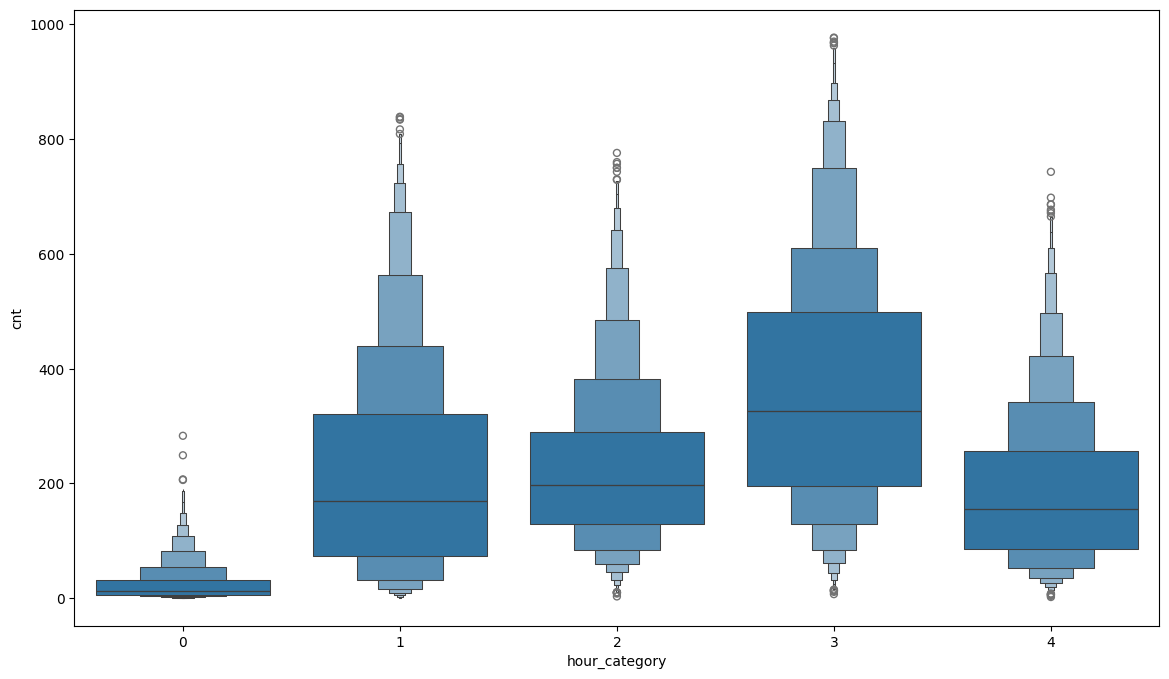

In [13]:
plt.figure(figsize=(14, 8)) 
sns.boxenplot(data=data, x='hour_category', y='cnt')


plt.show()

## Make a season column (season_actual)

Winter: December, January, February
	•	Spring: March, April, May
	•	Summer: June, July, August
	•	Fall: September, October, November


Where spring = 0, summer = 1, fall = 2, winter = 3

In [14]:
def map_season(month):
    if month in [12, 1, 2]:
        return '3'
    elif month in [3, 4, 5]:
        return '0'
    elif month in [6, 7, 8]:
        return '1'
    elif month in [9, 10, 11]:
        return '2'

data['season_actual'] = data['mnth'].apply(map_season)


In [15]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,hour_category,season_actual
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,0,3
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,0,3
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,0,3
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,0,3
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0,3


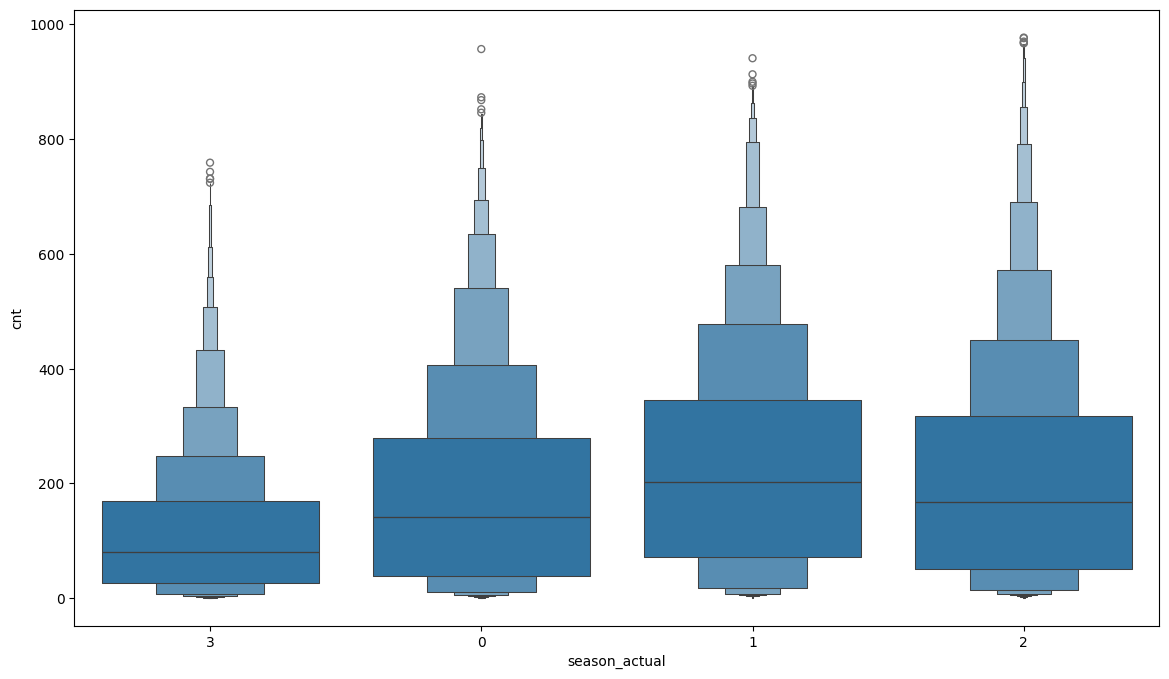

In [16]:
plt.figure(figsize=(14, 8))  # Adjust the size as needed
sns.boxenplot(data=data, x='season_actual', y='cnt')


plt.show()

## Create a column for weekday/weekend (weekday_weekend)

where 0 = weekday, 1 = weekend

In [29]:
def categorize_day(weekday):
    if 1 <= weekday < 6:
        return 0
    else:
        return 1

data['weekday_weekend'] = data['weekday'].apply(categorize_day)


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   instant          17379 non-null  int64  
 1   dteday           17379 non-null  object 
 2   season           17379 non-null  int64  
 3   yr               17379 non-null  int64  
 4   mnth             17379 non-null  int64  
 5   hr               17379 non-null  int64  
 6   holiday          17379 non-null  int64  
 7   weekday          17379 non-null  int64  
 8   workingday       17379 non-null  int64  
 9   weathersit       17379 non-null  int64  
 10  temp             17379 non-null  float64
 11  atemp            17379 non-null  float64
 12  hum              17379 non-null  float64
 13  windspeed        17379 non-null  float64
 14  casual           17379 non-null  int64  
 15  registered       17379 non-null  int64  
 16  cnt              17379 non-null  int64  
 17  hour_categor

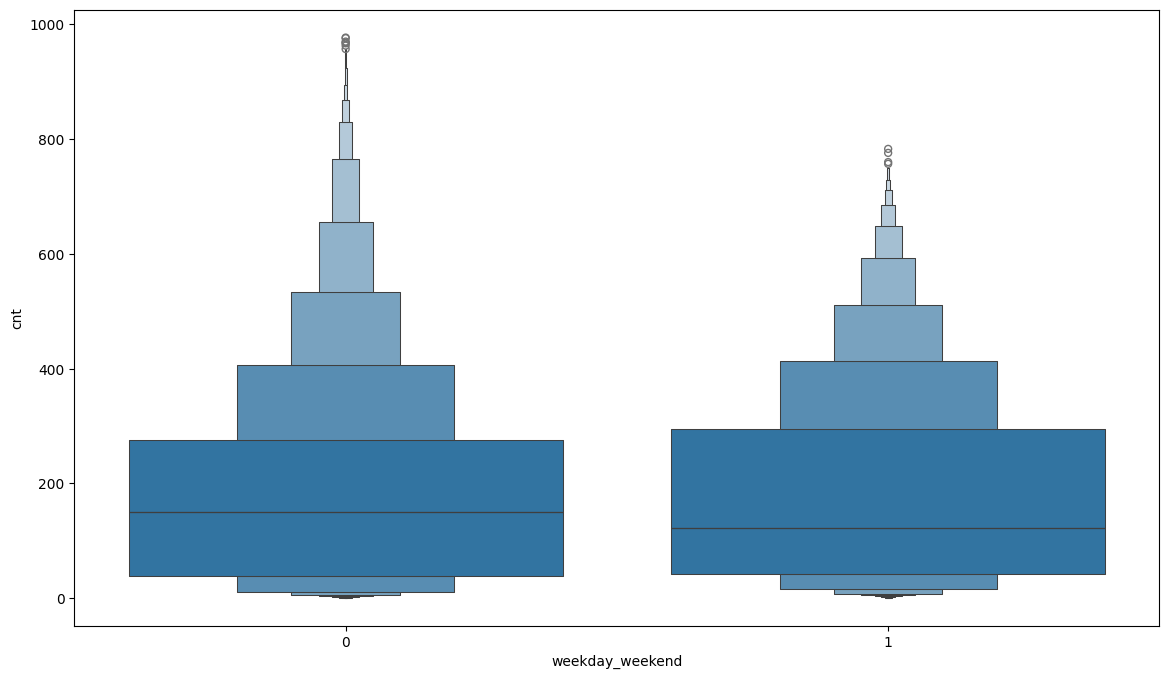

In [33]:
plt.figure(figsize=(14, 8))  # Adjust the size as needed
sns.boxenplot(data=data, x='weekday_weekend', y='cnt')


plt.show()

weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

## Create a column for rain (rain_snow)

where 0 = no rain or snow, 1 = rain or snow

In [37]:
def categorize_weather(weathersit):
    if 1 <= weathersit < 3:
        return 0
    else:
        return 1

data['rain_snow'] = data['weathersit'].apply(categorize_weather)


In [38]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,atemp,hum,windspeed,casual,registered,cnt,hour_category,season_actual,weekday_weekend,rain_snow
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.2879,0.81,0.0,3,13,16,0,3,1,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.2727,0.80,0.0,8,32,40,0,3,1,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.2727,0.80,0.0,5,27,32,0,3,1,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.2879,0.75,0.0,3,10,13,0,3,1,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.2879,0.75,0.0,0,1,1,0,3,1,0


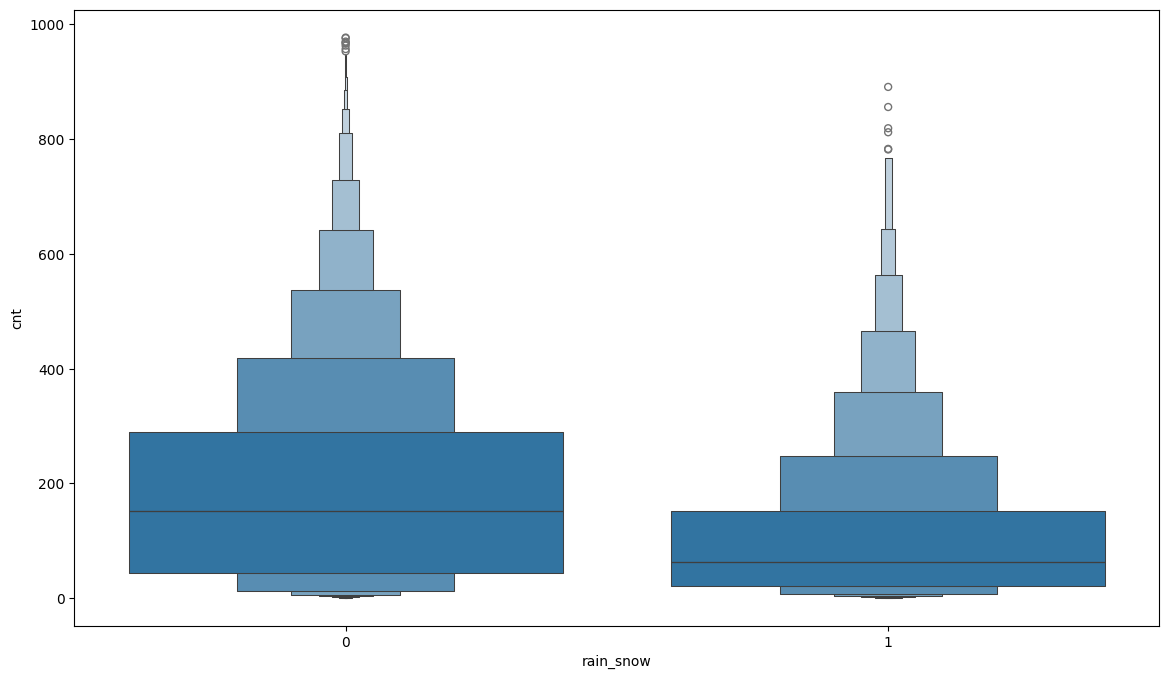

In [39]:
plt.figure(figsize=(14, 8))  # Adjust the size as needed
sns.boxenplot(data=data, x='rain_snow', y='cnt')


plt.show()

## Create a weather index (weather_index)

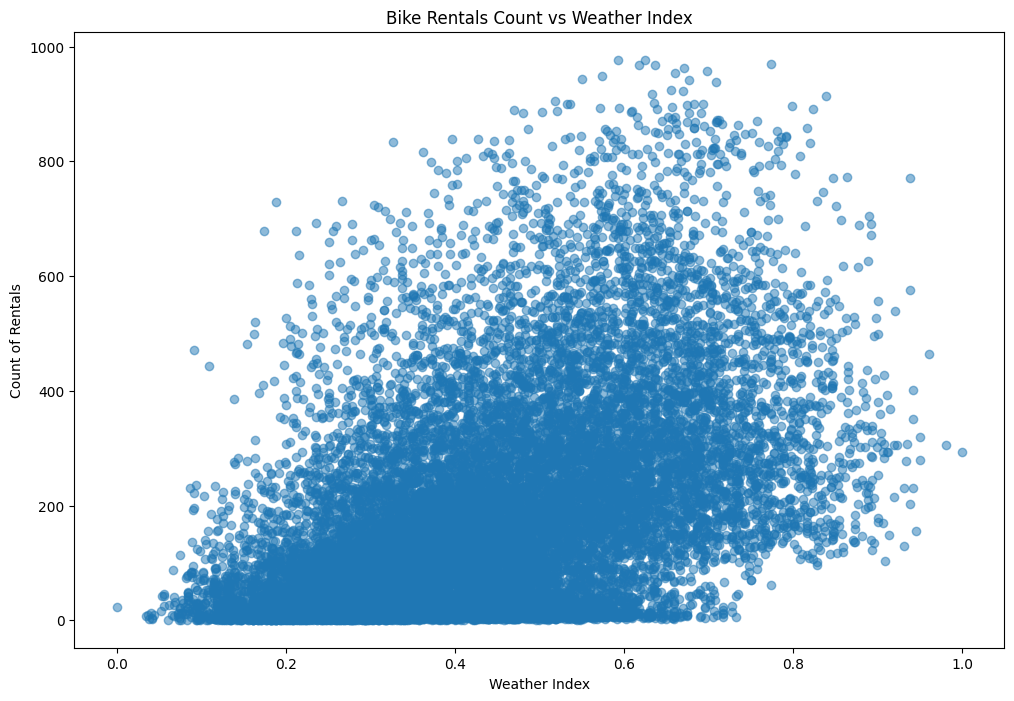

In [43]:
def calculate_weather_index(temp, hum, windspeed):
    # Normalize temperature (already normalized to 41)
    temp_factor = temp
    
    # Normalize humidity (already normalized to 100)
    hum_factor = hum
    
    # Normalize windspeed (already normalized to 67)
    wind_factor = windspeed
    
    # Calculate weather index
    # We're assuming that higher temperature is generally better for biking,
    # while higher humidity and wind speed are worse
    weather_index = temp_factor - (0.5 * hum_factor) - (0.3 * wind_factor)
    
    # Normalize the weather index to be between 0 and 1
    weather_index = (weather_index - weather_index.min()) / (weather_index.max() - weather_index.min())
    
    return weather_index

# Create the new column
data['weather_index'] = calculate_weather_index(data['temp'], data['hum'], data['windspeed'])



# Create a scatter plot to visualize the relationship between weather index and count
plt.figure(figsize=(12, 8))
plt.scatter(data['weather_index'], data['cnt'], alpha=0.5)
plt.title('Bike Rentals Count vs Weather Index')
plt.xlabel('Weather Index')
plt.ylabel('Count of Rentals')
plt.show()



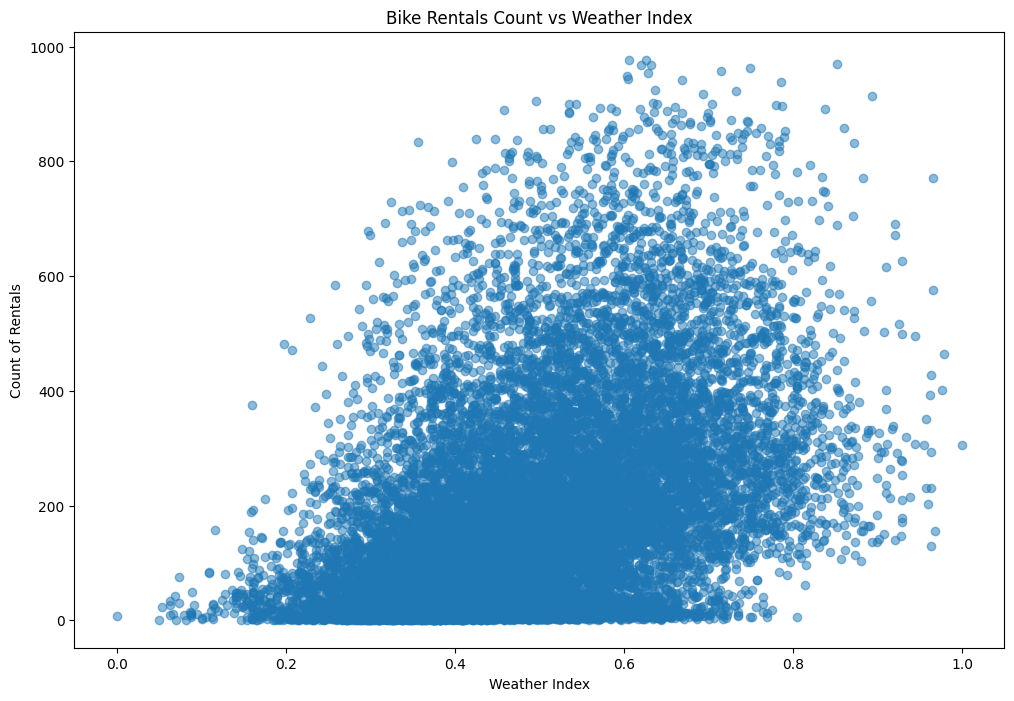

In [58]:
def calculate_weather_index(temp, hum, windspeed):
    # Normalize temperature (already normalized to 41)
    temp_factor = temp
    
    # Normalize humidity (already normalized to 100)
    hum_factor = hum
    
    # Normalize windspeed (already normalized to 67)
    wind_factor = windspeed
    
    # Calculate weather index
    # We're assuming that higher temperature is generally better for biking,
    # while higher humidity and wind speed are worse
    weather_index = temp_factor - (0.8 * hum_factor) - (wind_factor)
    
    # Normalize the weather index to be between 0 and 1
    weather_index = (weather_index - weather_index.min()) / (weather_index.max() - weather_index.min())
    
    return weather_index

# Create the new column
data['weather_index'] = calculate_weather_index(data['temp'], data['hum'], data['windspeed'])



# Create a scatter plot to visualize the relationship between weather index and count
plt.figure(figsize=(12, 8))
plt.scatter(data['weather_index'], data['cnt'], alpha=0.5)
plt.title('Bike Rentals Count vs Weather Index')
plt.xlabel('Weather Index')
plt.ylabel('Count of Rentals')
plt.show()



## Create an optimised weather index using a gridsearch for wind and humidity weights

Best humidity weight: 0.8
Best wind weight: 0.0
Best correlation: 0.5009904376253108


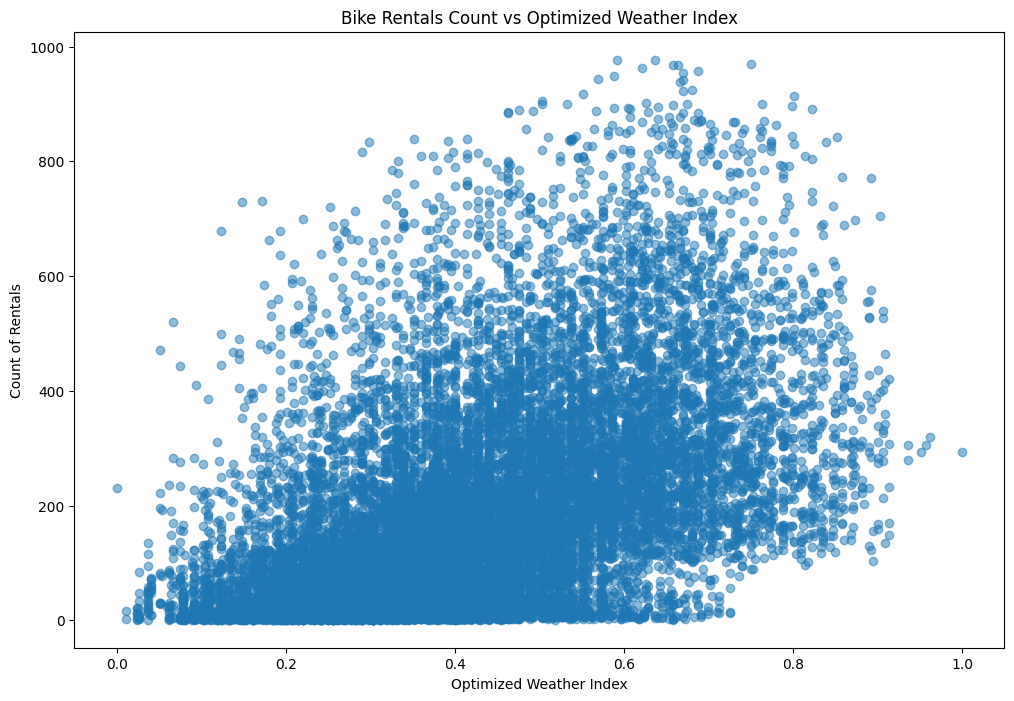

Correlation with original weather index: 0.4793289777410211
Correlation with optimized weather index: 0.5009904376253108


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def calculate_weather_index(temp, hum, windspeed, hum_weight, wind_weight):
    weather_index = temp - (hum_weight * hum) - (wind_weight * windspeed)
    return (weather_index - weather_index.min()) / (weather_index.max() - weather_index.min())

# Define the range of weights to try
hum_weights = np.arange(0, 1.1, 0.1)
wind_weights = np.arange(0, 1.1, 0.1)

best_correlation = 0
best_hum_weight = 0
best_wind_weight = 0

# Perform grid search
for hum_weight in hum_weights:
    for wind_weight in wind_weights:
        weather_index = calculate_weather_index(data['temp'], data['hum'], data['windspeed'], hum_weight, wind_weight)
        correlation, _ = pearsonr(weather_index, data['cnt'])
        
        if abs(correlation) > abs(best_correlation):
            best_correlation = correlation
            best_hum_weight = hum_weight
            best_wind_weight = wind_weight

print(f"Best humidity weight: {best_hum_weight}")
print(f"Best wind weight: {best_wind_weight}")
print(f"Best correlation: {best_correlation}")

# Calculate the optimized weather index
data['optimized_weather_index'] = calculate_weather_index(data['temp'], data['hum'], data['windspeed'], best_hum_weight, best_wind_weight)

# Create a scatter plot to visualize the relationship between optimized weather index and count
plt.figure(figsize=(12, 8))
plt.scatter(data['optimized_weather_index'], data['cnt'], alpha=0.5)
plt.title('Bike Rentals Count vs Optimized Weather Index')
plt.xlabel('Optimized Weather Index')
plt.ylabel('Count of Rentals')
plt.show()

# Compare correlation of original and optimized weather index with cnt
original_correlation, _ = pearsonr(data['weather_index'], data['cnt'])
optimized_correlation, _ = pearsonr(data['optimized_weather_index'], data['cnt'])

print(f"Correlation with original weather index: {original_correlation}")
print(f"Correlation with optimized weather index: {optimized_correlation}")

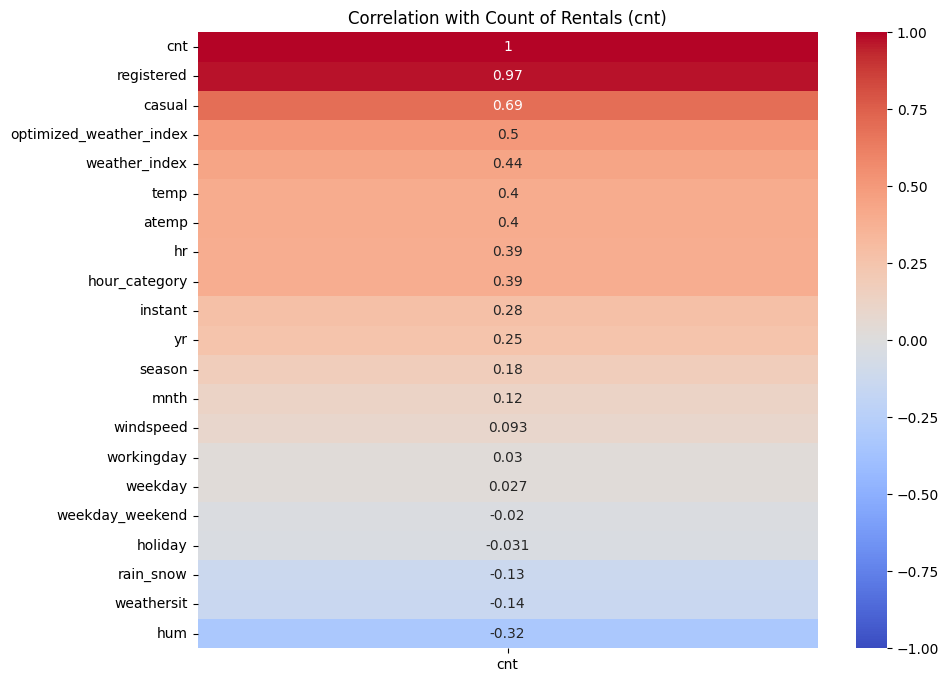

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap of the correlation matrix with focus on 'cnt'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['cnt']].sort_values(by='cnt', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Count of Rentals (cnt)')
plt.show()

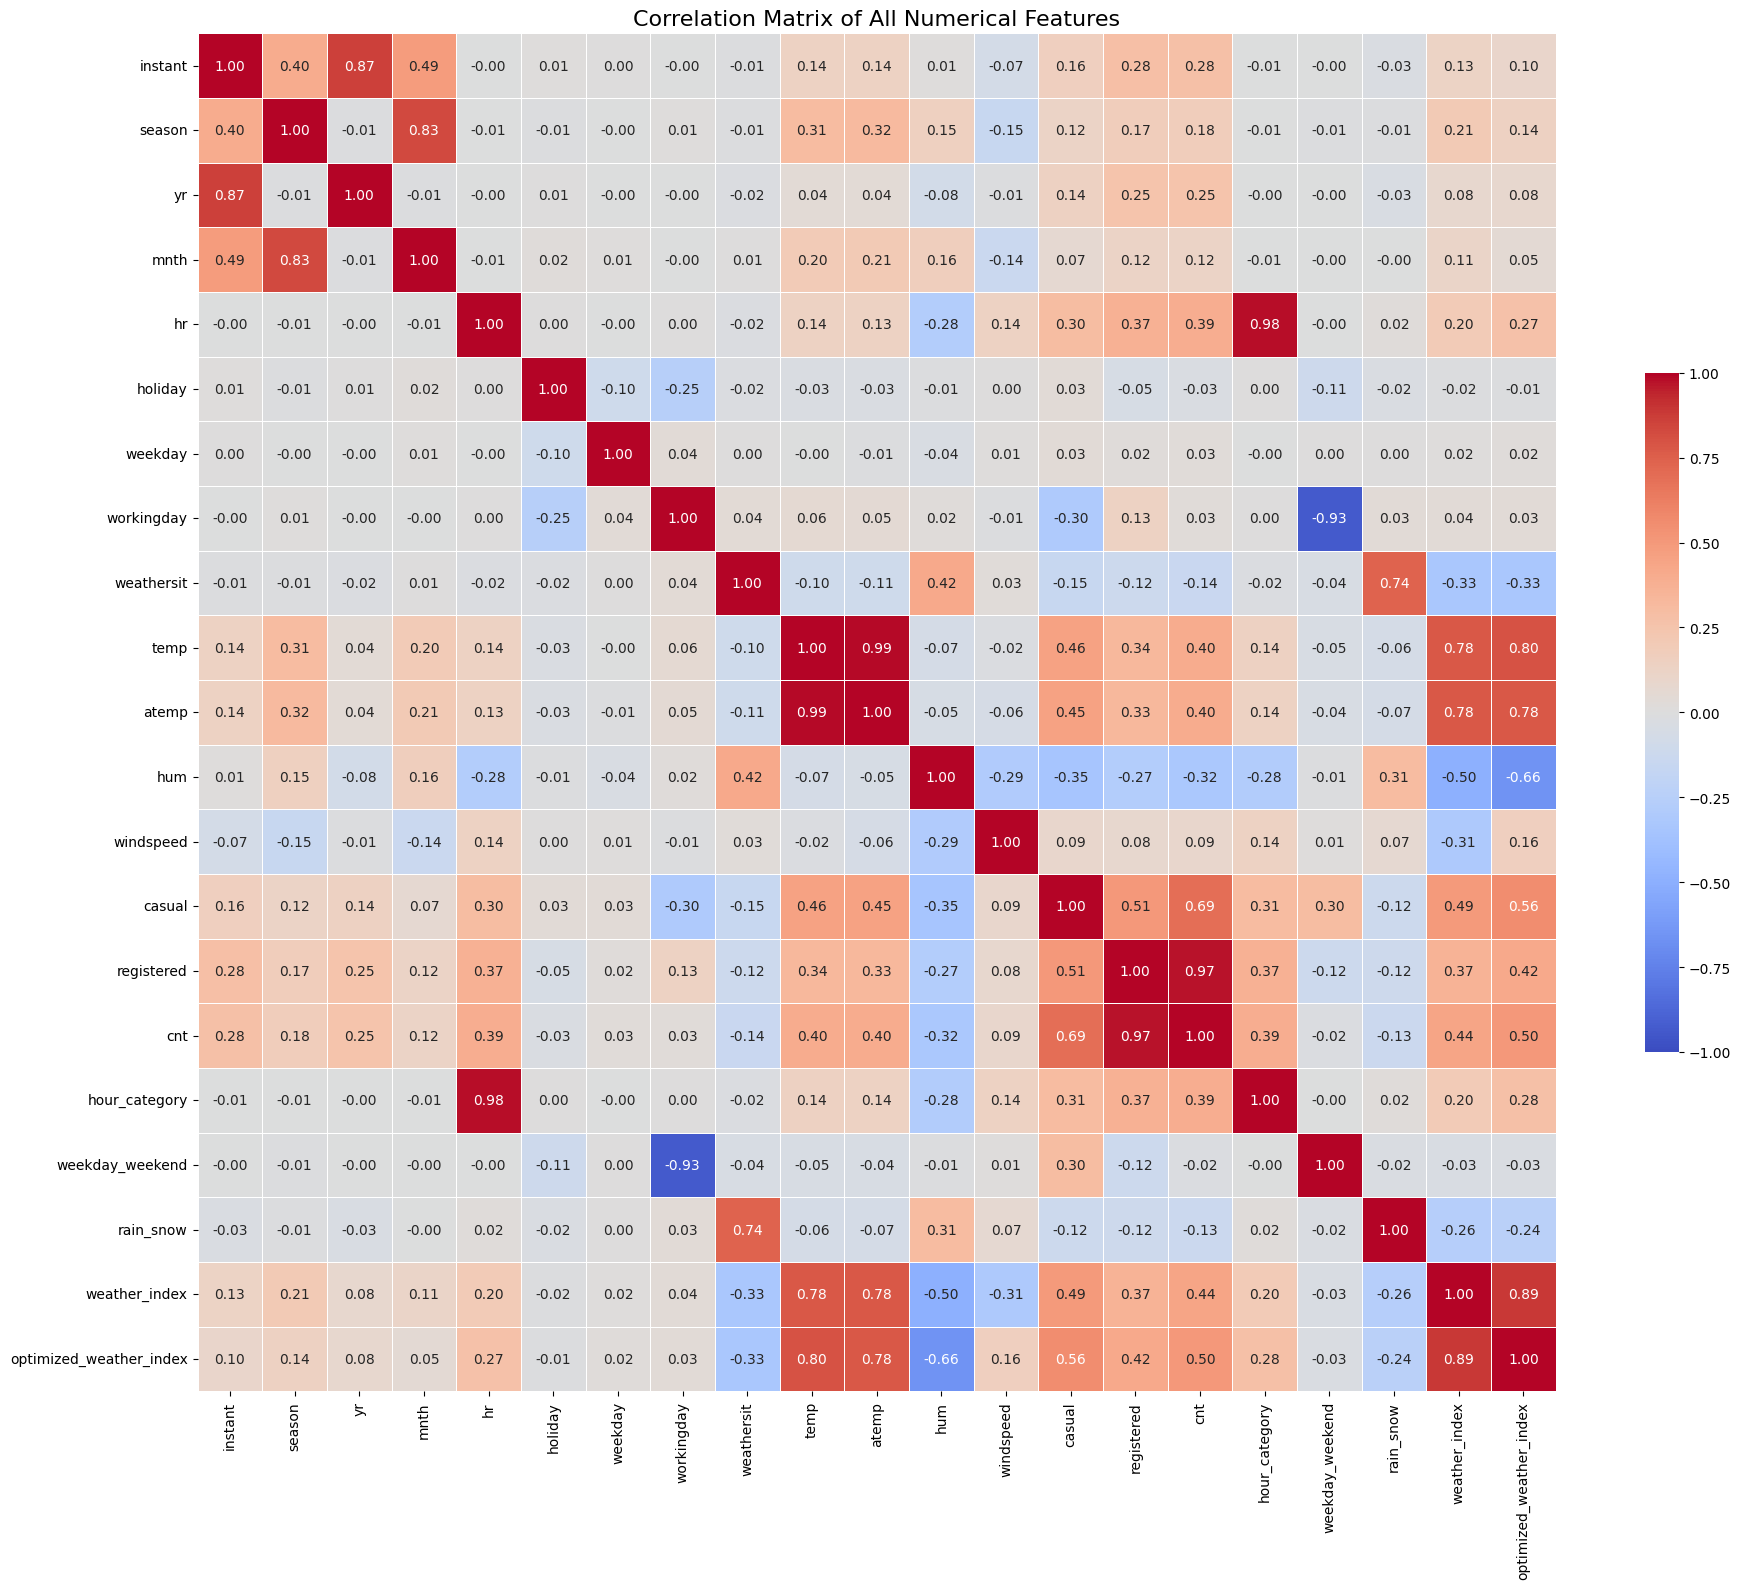

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap of the correlation matrix for all numerical features
plt.figure(figsize=(20, 16))  # Increased figure size for better readability
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            fmt='.2f',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .5})

plt.title('Correlation Matrix of All Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

## PART III: Streamlit dashboard

In [4]:
### This part goes in a separate script ###